## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusions](#conclusions)
- [Resources](#resources)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df.query("(group == 'treatment' and landing_page == 'old_page') or \
          (group == 'control' and landing_page == 'new_page')").shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum() # None of the rows have missing values

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. 

a. Now, remove the rows that not meet the specifications above to create a new dataframe. Store your new dataframe in **df2**.

In [8]:
df2 = df.drop(df.query("(group == 'treatment' and landing_page == 'old_page') or \
                        (group == 'control' and landing_page == 'new_page')").index, axis=0)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer some questions.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2 = df2.drop(df2[df2.user_id.duplicated()].index, axis=0)
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted


`4.` Use **df2** in the below cells to answer some more questions.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2.query("group == 'control'").converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2.query("group == 'treatment'").converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
df2.query("landing_page == 'new_page'").shape[0] / df2.shape[0] 

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**If we look at the sample data, the probability of conversion in the treatment group was 11.88% and in the control group was 12.04%. Looking at these probabilities, we would have said that the new page leads to a lower likelihood of conversion when compared to the old page.**

**However, the observed difference in this sample was only -0.16%, and now we have to see if this difference is significant and not just due chance.** 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$ H_0: p_{new} - p_{old} \le 0 $$
$$ H_1: p_{new} - p_{old} \gt 0 $$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [20]:
n_new = df2.query("landing_page == 'new_page'").shape[0]
n_new

145310

d. What is $n_{old}$?

In [21]:
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.choice([0, 1],size=n_new, p=[1-p_new, p_new])
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.choice([0, 1],size=n_old, p=[1-p_old, p_old])
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
new_page_converted.mean() - old_page_converted.mean()

5.988593447597834e-05

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [25]:
p_diffs = np.array([])
for _ in range(10000):
    new_sample = np.random.choice([0, 1],size=n_new, p=[1-p_new, p_new])
    old_sample = np.random.choice([0, 1],size=n_old, p=[1-p_old, p_old])
    
    p_diff = new_sample.mean() - old_sample.mean()
    p_diffs = np.append(p_diffs, p_diff)
    
p_diffs[:5]

array([-0.00188791, -0.00047687, -0.0004978 , -0.00133063,  0.00043159])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [26]:
# the difference between the observed convert rates
obs_diff = df2.query("group == 'treatment'").converted.mean() - df2.query("group == 'control'").converted.mean()
obs_diff

-0.0015782389853555567

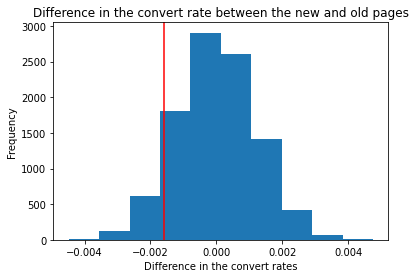

In [27]:
plt.hist(p_diffs)
plt.title("Difference in the convert rate between the new and old pages")
plt.xlabel("Difference in the convert rates")
plt.ylabel("Frequency")
plt.axvline(x=obs_diff, color="red");

**The plot shows a normal distribution as expected by the Central Limit Theorem - when we use the difference in proportions as a statistic and a large enough sample size, the sampling distribution will be normally distributed. The histogram is centered at 0 as expected, because the sampling distribution was estimated from the null hypothesis with $p_{new} - p_{old} = 0$.**

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
(p_diffs > obs_diff).mean()

0.9056

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The value computed in part `j.` is called p-value. This is the probability of observing the statistic or a more extreme value in favor of the alternative hypothesis, if the null hypothesis is true. The p-value helps us make a decision, because of the way we construct our assumptions, when calculated, the p-value tells us the probability of committing a type I error ($\alpha$) if the null hypothesis is true - a type I error is when we incorrectly reject the null hypothesis.**

**Since the p-value is higher than $\alpha$, which is 5%, we fail to reject the null hypothesis. So, we would not recommend to launch the new page.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = df2.query("landing_page == 'old_page'").converted.sum()
convert_new = df2.query("landing_page == 'new_page'").converted.sum()
n_old, n_new

(145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [30]:
sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], 0, alternative="larger")

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The z-score and the p-value found in `m.` agree with the results in parts `j.` and `k.`, where we fail to reject the null hypothesis, once the p-value (90.5%) is greater than $\alpha$ (5%). So, we would not recommend to launch the new page.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**I would perform a Logistic Regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
# Include an intercept in the dataframe
df2["intercept"] = 1

# Create the ab_page column with 1 when the individual receives the treatment and 0 if control.
df2[["control", "ab_page"]] = pd.get_dummies(df.group)
df2 = df2.drop("control", axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [32]:
# Logit regression model
logit_mod = sm.Logit(df2.converted, df2[["intercept", "ab_page"]])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [33]:
# Summary of the Logit regression model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290584
Method:                           MLE   Df Model:                           -1
Date:                Sun, 07 Feb 2021   Pseudo R-squ.:               8.077e-06
Time:                        16:48:19   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [34]:
# The exponential from the coefficients
np.exp(results.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

In [35]:
# The reciprocal from the exponentiated coefficients
1/np.exp(results.params)

intercept    7.306593
ab_page      1.015102
dtype: float64

**In the treatment group, the chance of convertion is 1.051 times more likely than in the control group, holding all else constant.**

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>

**The p-value associated with `ab_page` is 19%. This value is different from the value found in Part II, which is 90.5%, because the hypothesis test made in the logistic regression model has a two-sided hypothesis, that is:**

$$ H_0: \beta_1 = 0 $$
$$ H_1: \beta_1 \ne 0 $$ 

where $\beta_1$ is the population coefficient associated with the `ab_page` variable. 

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**We should consider others factors into the regression model as they might influence the response too. The set of factors can influence the response in a way that each individual factor would not be capable.**

**However, adding additional terms into the regresion model can leave to some problems, like multicollinearity, and when not addressed in the right way, can generate unreliable coefficients. Multicollinearity is when we have predictor variables (x-variables) that are correlated with one another. One of the main concerns of multicollinearity is that it can lead to coefficients being flipped from the direction we expect from a simple regression.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns. Provide the statistical output as well as a written response to answer this question.

In [36]:
# Read the country.csv into a dataframe
countries_df = pd.read_csv("countries.csv")
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [37]:
# Merge the df2 dataframe and the country datafram to create the df_new
df_new = df2.merge(countries_df, on="user_id", how="inner")
df_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [38]:
# Create the necessary dummy variables
country_dummies = pd.get_dummies(df_new.country)
df_new = df_new.join(country_dummies)
df_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [39]:
# Logit regression model
logit_mod = sm.Logit(df_new.converted, df_new[["intercept", "ab_page", "US", "UK"]])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 07 Feb 2021   Pseudo R-squ.:               2.323e-05
Time:                        16:48:22   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

In [40]:
# The exponential from the coefficients
np.exp(results.params)

intercept    0.131332
ab_page      0.985168
US           1.041599
UK           1.051944
dtype: float64

In [41]:
# The reciprocal from the exponentiated intercept and ab_page coefficients
1/np.exp(results.params)[0:2] 

intercept    7.614303
ab_page      1.015056
dtype: float64

**No, it appears that country doesn't have a significant impact on the conversion rate, based on the p-values, once that all the values are higher than the type I error $(\alpha = 5\%)$. So, we fail to reject the null hypothesis and we would not recommend to launch the new page.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [42]:
# Create the interactions columns between the countries columns and the page column (ab_page)
df_new["US_page"] = df_new.ab_page * df_new.US
df_new["UK_page"] = df_new.ab_page * df_new.UK
df_new["CA_page"] = df_new.ab_page * df_new.CA
df_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,US_page,UK_page,CA_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0,0


In [43]:
# Logit regression model
logit_mod = sm.Logit(df_new.converted, df_new[["intercept", "ab_page", "US", "UK", "US_page", "UK_page"]])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sun, 07 Feb 2021   Pseudo R-squ.:               3.482e-05
Time:                        16:48:24   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US_page        0.0469      0.054      0.872      0.383      -0.059       0.152
UK_page        0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""

**Once again, based on the p-values, all the variables are not statistically significant in predicting if someone will convert or not. So, we fail to reject the null hypothesis and we would not recommend to launch the new page.**

<a id='conclusions'></a>
## Conclusions

The goal of this notebook is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision. Looking all the results calculated by differents methods, I do not have sufficient evidence to suggest that the new page would increase the number of users who "convert", meaning the number of users who decide to pay for the company's product.

<a id='resources'></a>
## Resources

- Videos and resources from the Data Analyst Nanodegree Program from Udacity
- [Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf)
- [Statistical Significance Explained](https://towardsdatascience.com/statistical-significance-hypothesis-testing-the-normal-curve-and-p-values-93274fa32687)